In [2]:
import matplotlib.pyplot as plt
from helpers.cm26 import DatasetCM26, operator_Kochkov, operator_coarsen, operator_gaussian
from helpers.computational_tools import select_NA, select_Pacific, select_Cem, select_Equator, StateFunctions, compare
from helpers.ann_tools import ANN, import_ANN, minibatch, export_ANN
import torch
import torch.optim as optim
import numpy as np
from time import time
import json
import warnings
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 3

# Rotation of input features

In [50]:
x = torch.arange(9).reshape(3,3)

In [54]:
x

tensor([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]])

## Standard feature extraction

In [55]:
x.unfold(0,3,1).unfold(1,3,1)[0,0]

tensor([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]])

## Rotation 90 degrees conter-clockwise

In [56]:
x.unfold(1,3,1).flip(-1).unfold(0,3,1)[0,0]

tensor([[2, 5, 8],
        [1, 4, 7],
        [0, 3, 6]])

## Rotation 180 degrees conter-clockwise

In [57]:
x.unfold(0,3,1).flip(-1).unfold(1,3,1).flip(-1)[0,0]

tensor([[8, 7, 6],
        [5, 4, 3],
        [2, 1, 0]])

## Rotation 270 degrees conter-clockwise

In [58]:
x.unfold(1,3,1).unfold(0,3,1).flip(-1)[0,0]

tensor([[6, 3, 0],
        [7, 4, 1],
        [8, 5, 2]])

# Test rotational symmetry on ANN inference

In [3]:
ds = DatasetCM26()

In [4]:
dataset = ds.sample_epoch(time=np.random.randint(6950,8035))[4]

In [128]:
ann_Txy = import_ANN('trained_models/ANN_CM26/Txy_epoch_2000.nc')
ann_Txx_Tyy = import_ANN('trained_models/ANN_CM26/Txx_Tyy_epoch_2000.nc')

# Determining unique symmetries

In [161]:
keys = []
values = []
for rotation in [0, 90]:
    for reflect_x in [False, True]:
        for reflect_y in [False, True]:
            test = dataset.state.ANN(ann_Txy, ann_Txx_Tyy, 
                rotation=rotation, reflect_x=reflect_x, reflect_y=reflect_y)
            val = np.linalg.norm(test['ZB20u'].data.ravel()) + np.linalg.norm(test['ZB20v'].data.ravel())
            values.append(val)
            keys.append(f'{rotation}-{reflect_x}-{reflect_y}')

In [162]:
# Note 8 is the maximum even if increase the number of available rotations
print(len(np.unique(values)))

8


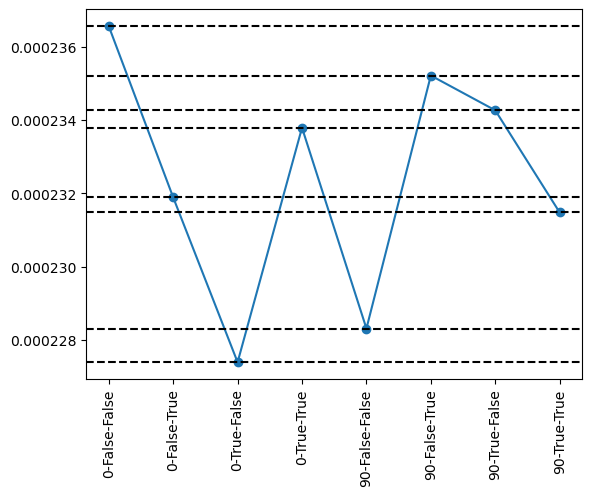

In [163]:
plt.plot(values,marker='o')
plt.xticks(np.arange(len(values)), keys, rotation=90)
for val in np.unique(values):
    plt.axhline(y=val, color='k', ls='--')

# Testing symmetries on trained model

In [5]:
%time dataset = ds.sample_epoch(time=np.random.randint(6950,8035), operator=operator_Kochkov, factors=[4])[4]

CPU times: user 2.39 s, sys: 1.14 s, total: 3.53 s
Wall time: 3.38 s


In [8]:
ann_Txy = import_ANN('trained_models/ANN_CM26_Kochkov_augmented/Txy_epoch_100.nc')
ann_Txx_Tyy = import_ANN('trained_models/ANN_CM26_Kochkov_augmented/Txx_Tyy_epoch_100.nc')
%time ann = dataset.state.ANN(ann_Txy, ann_Txx_Tyy, rotation=0)

CPU times: user 1.08 s, sys: 505 ms, total: 1.58 s
Wall time: 269 ms


Correlation: 0.95085327882532
Relative Error: 0.35283077100886323
R2 =  0.8987036270038082
R2 max =  0.9042063612808787
Optinal scaling: 0.9276343737367977
Nans [test/control]: [0, 0]


Correlation: 0.938030266550939
Relative Error: 0.40028456178369193
R2 =  0.8774283907597626
R2 max =  0.879917750160406
Optinal scaling: 0.9494970903508064
Nans [test/control]: [0, 0]


Correlation: 0.9519479048368338
Relative Error: 0.3456237541511029
R2 =  0.9005627298867912
R2 max =  0.9062890890154028
Optinal scaling: 0.926364409129667
Nans [test/control]: [0, 0]


Correlation: 0.9462347378038095
Relative Error: 0.3757573304846691
R2 =  0.894342663482135
R2 max =  0.8953749305183004
Optinal scaling: 0.9671608232972091
Nans [test/control]: [0, 0]


Correlation: 0.9646912879241516
Relative Error: 0.32109283256461996
R2 =  0.9278661601832754
R2 max =  0.9306910549261849
Optinal scaling: 0.9477835284013733
Nans [test/control]: [0, 0]


Correlation: 0.9526139846210594
Relative Error: 0.357559539772105
R2

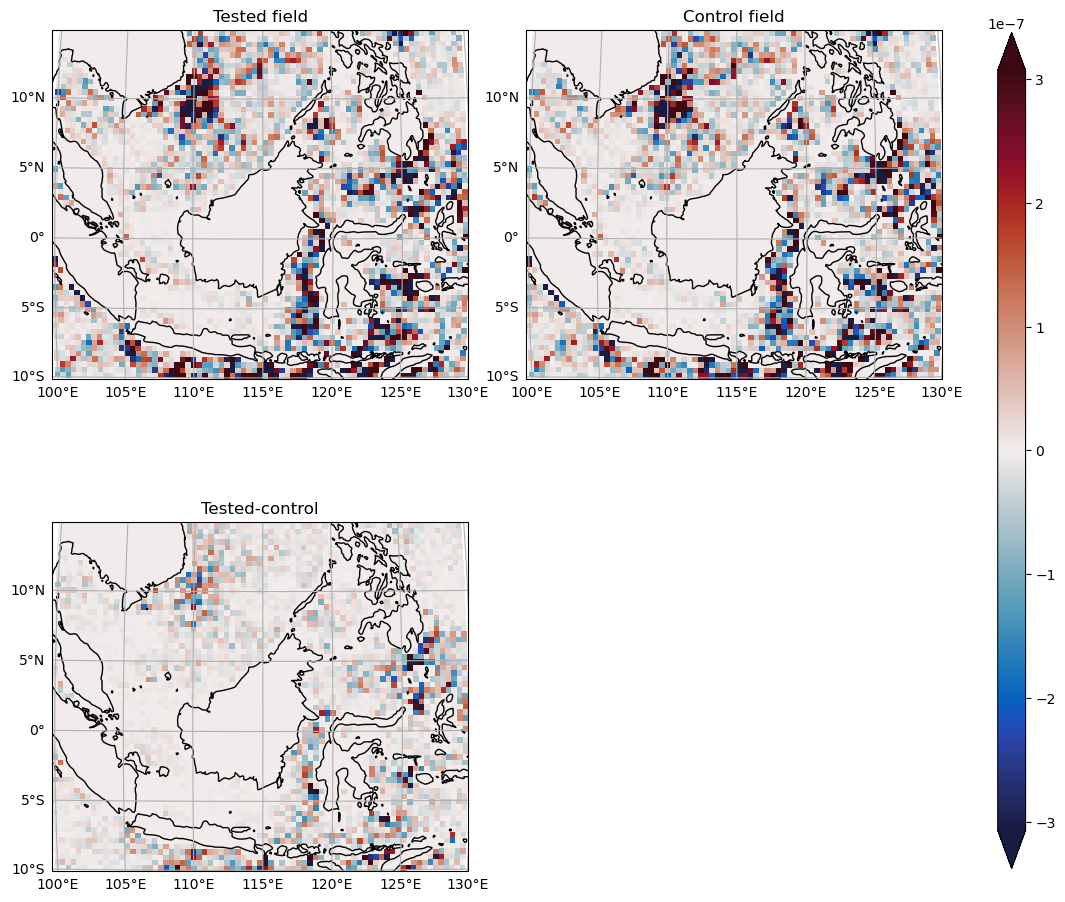

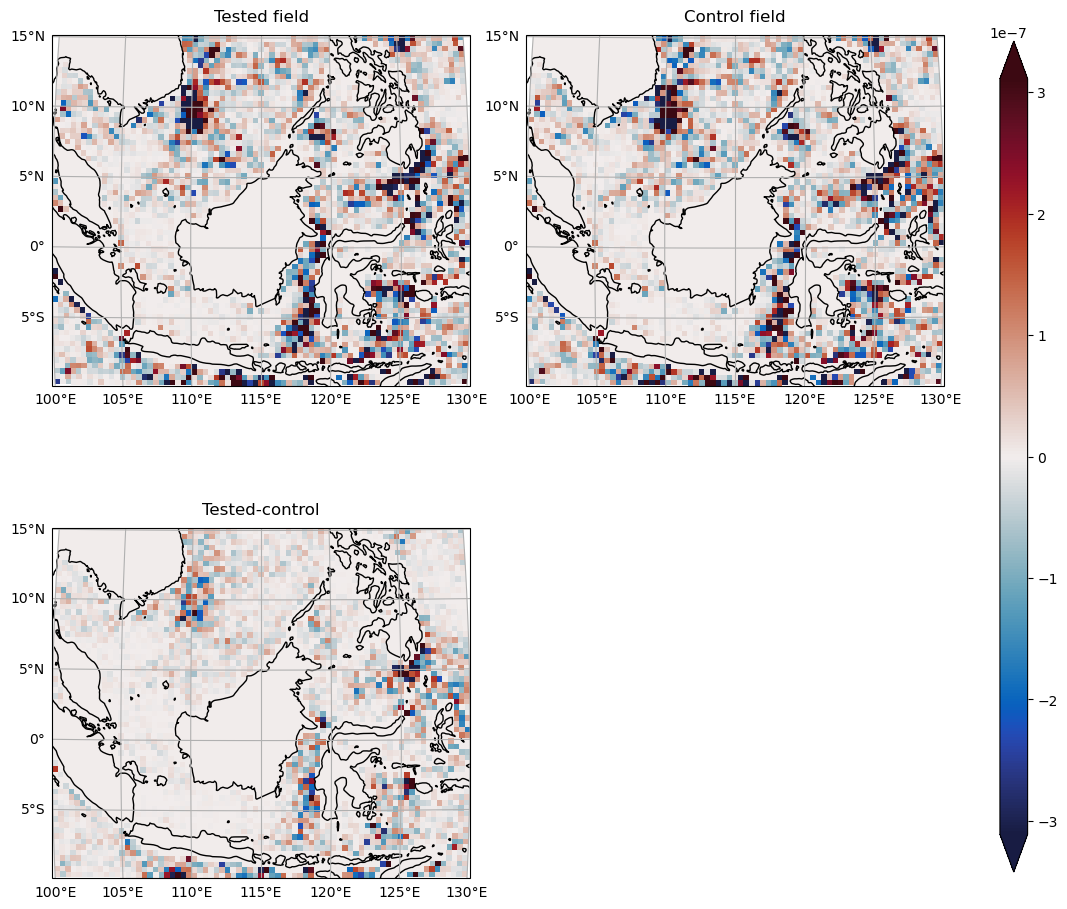

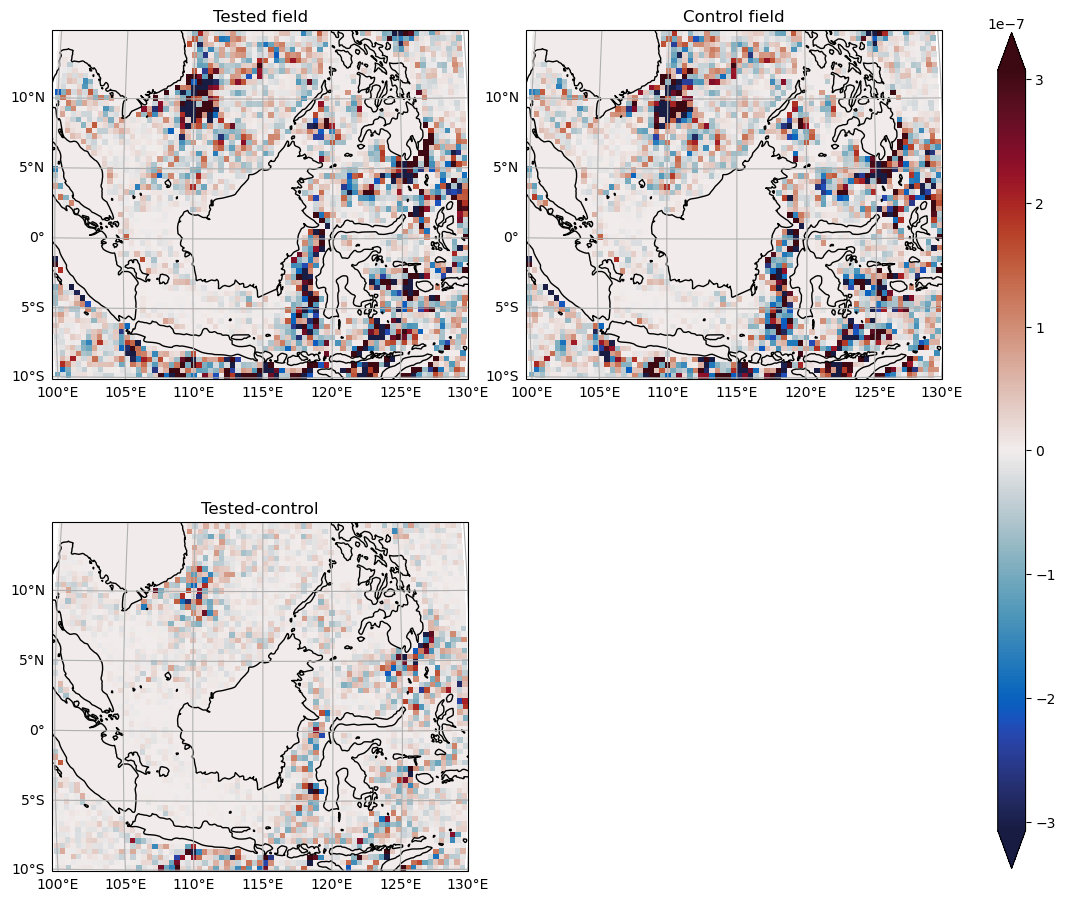

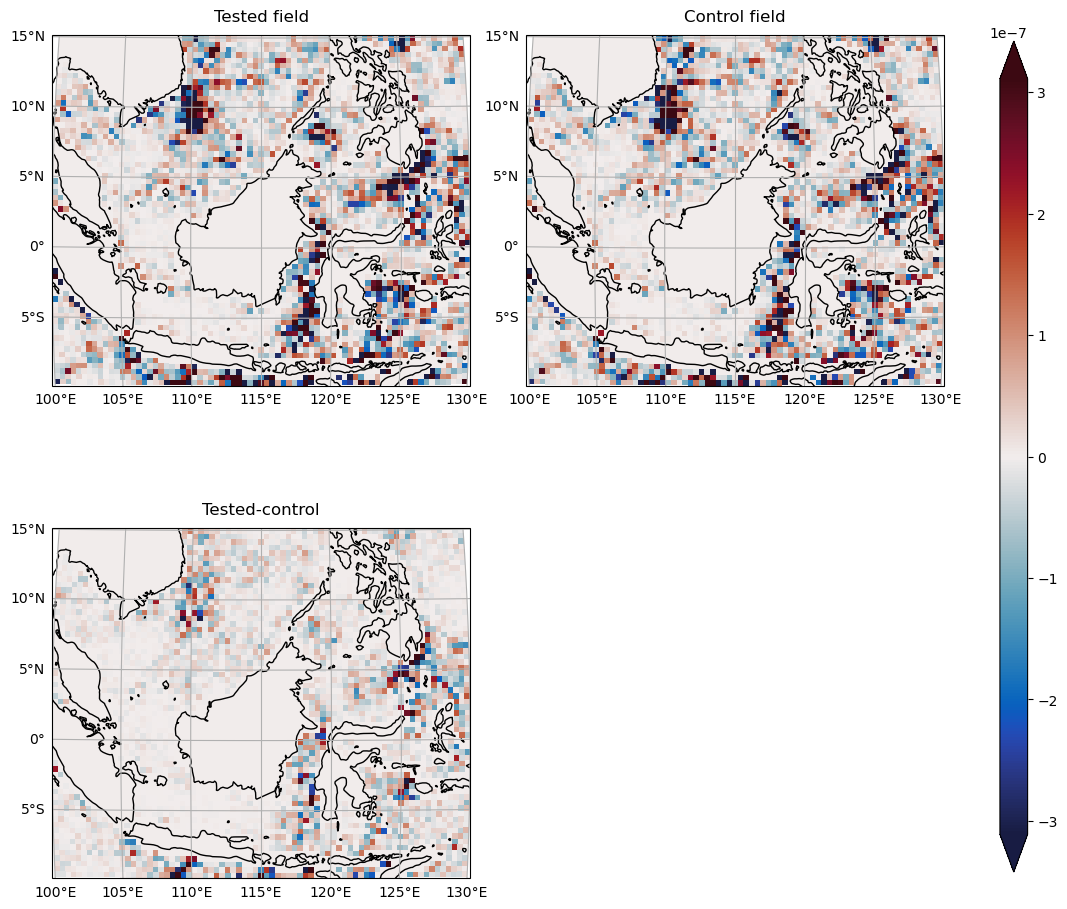

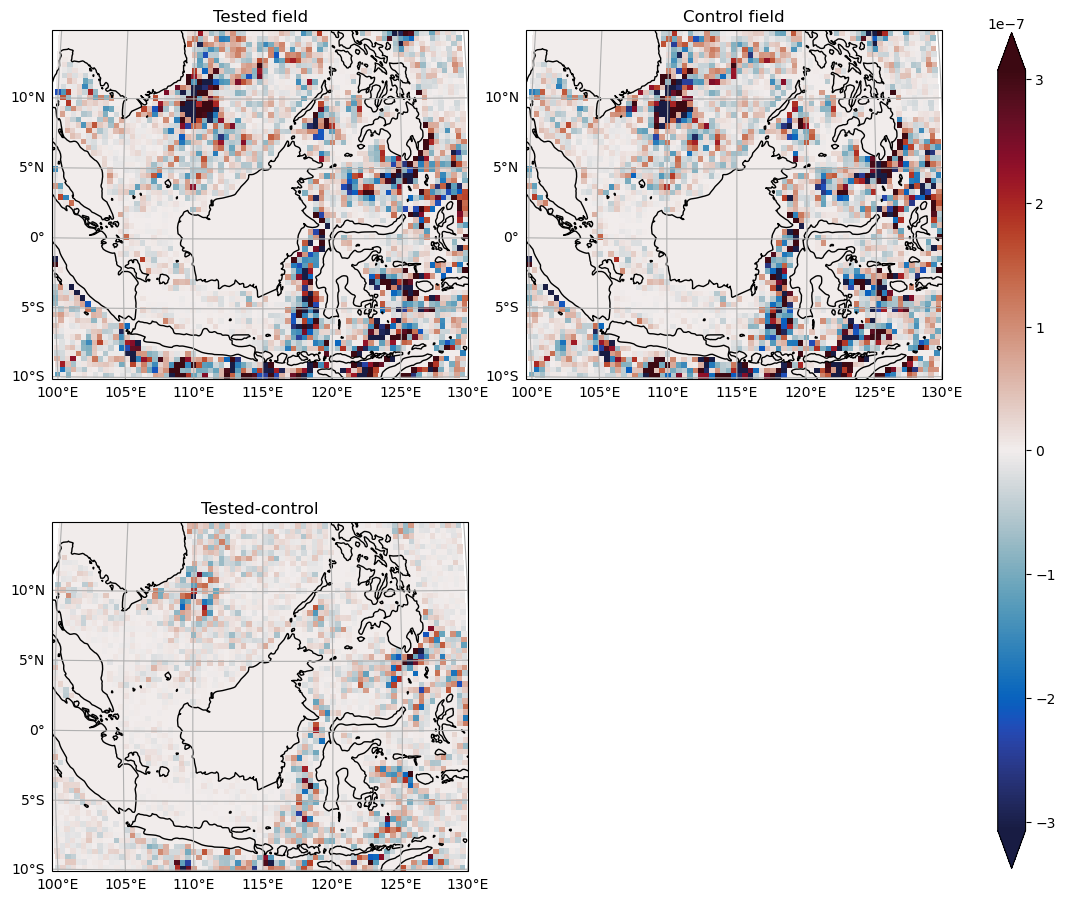

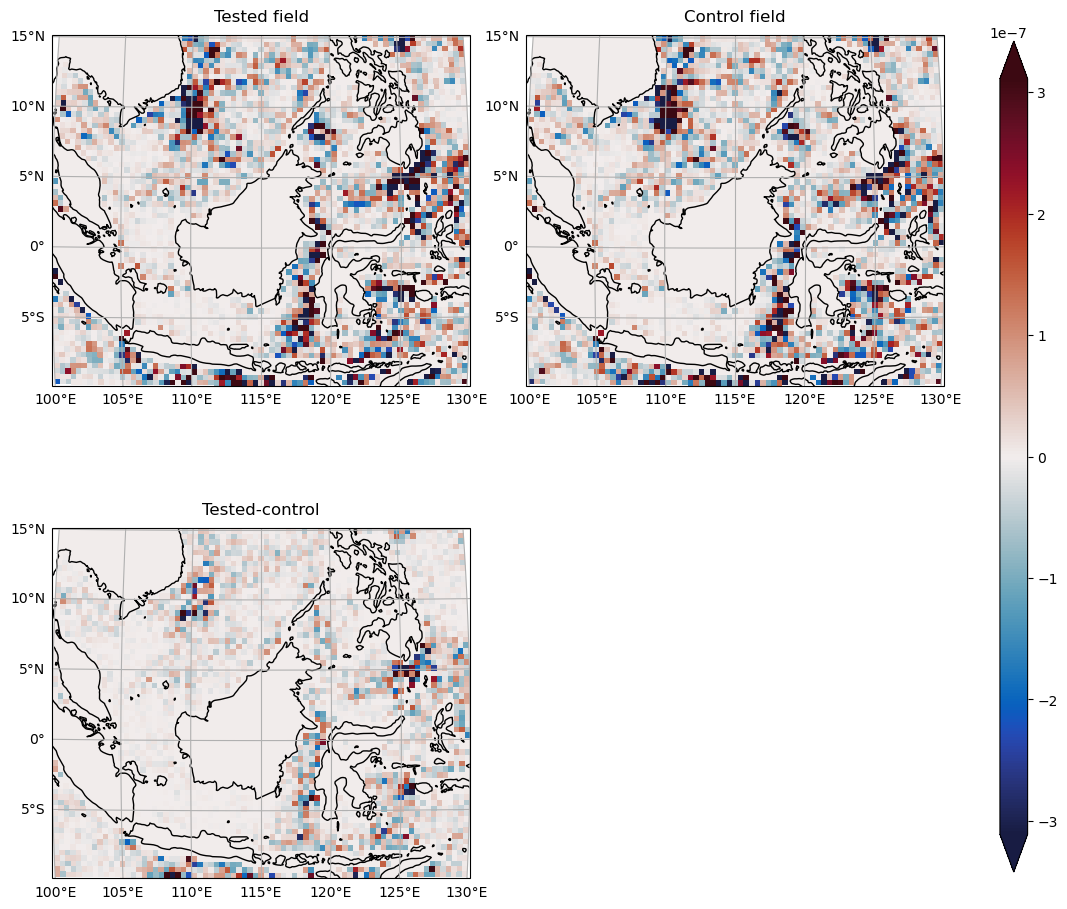

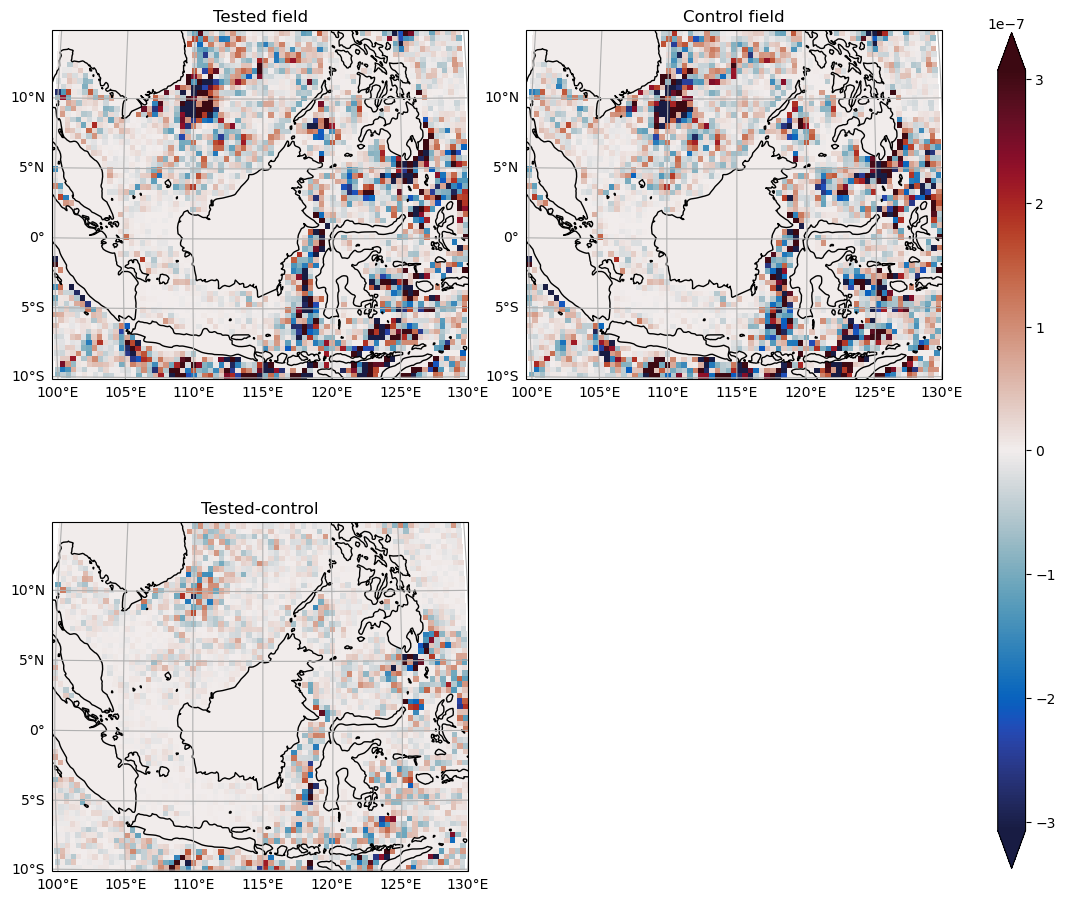

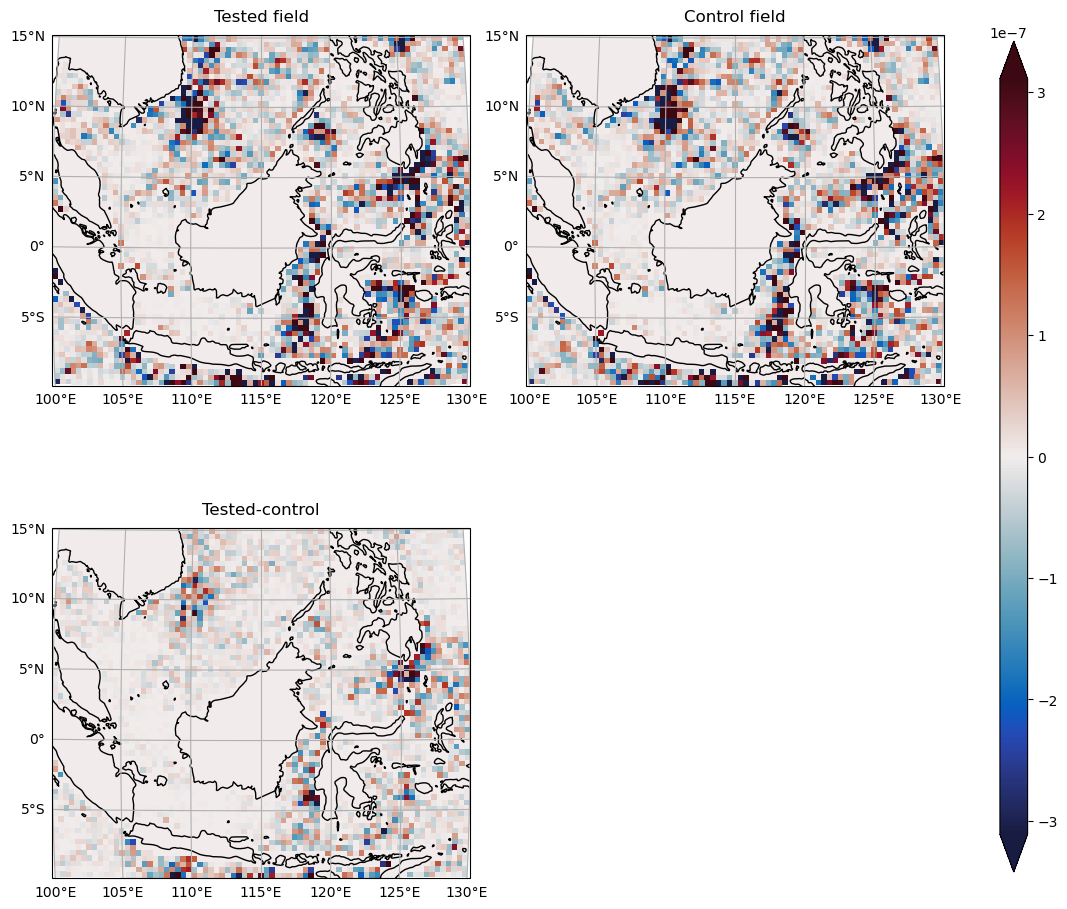

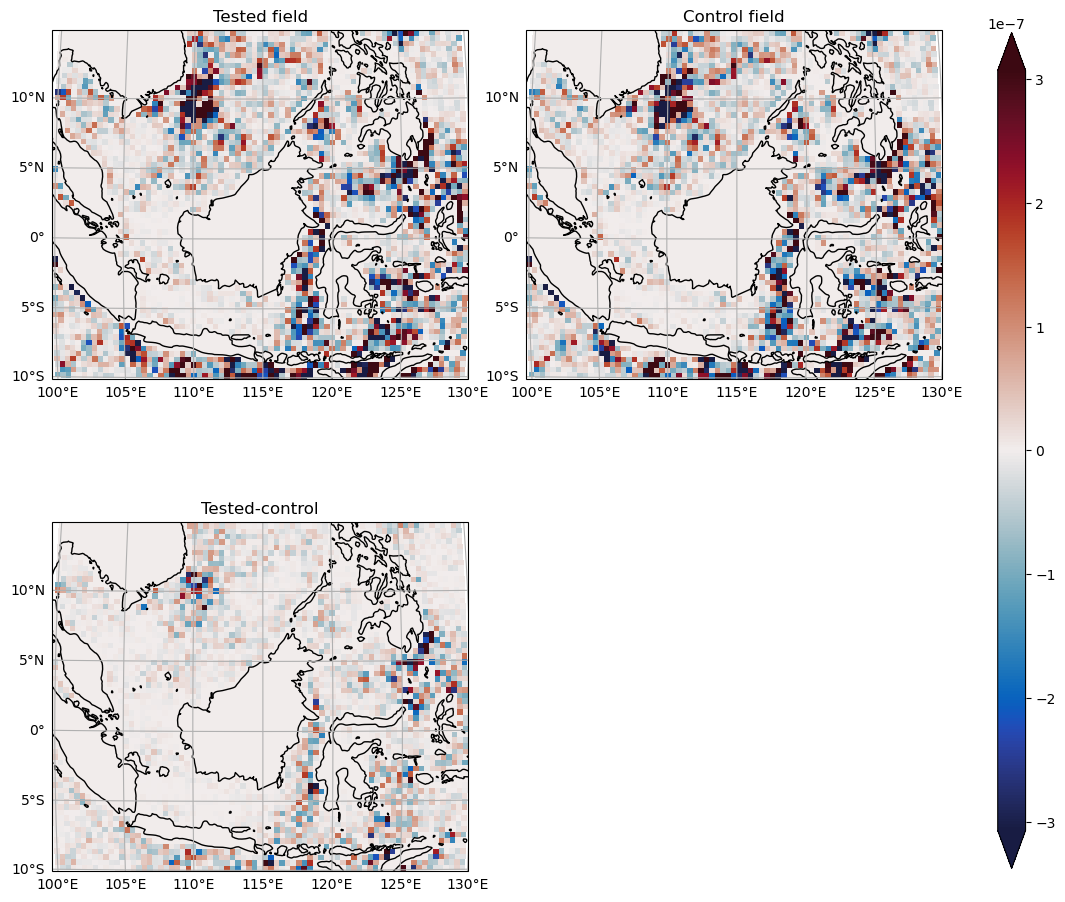

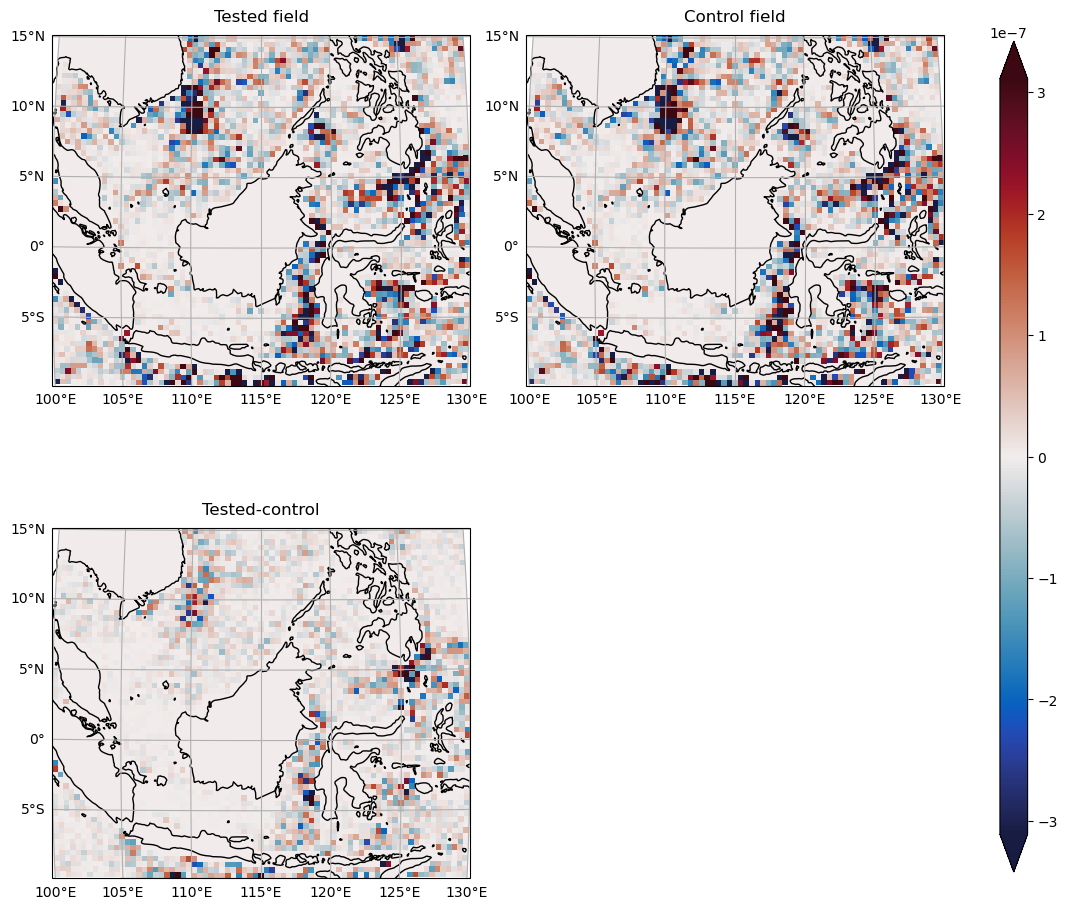

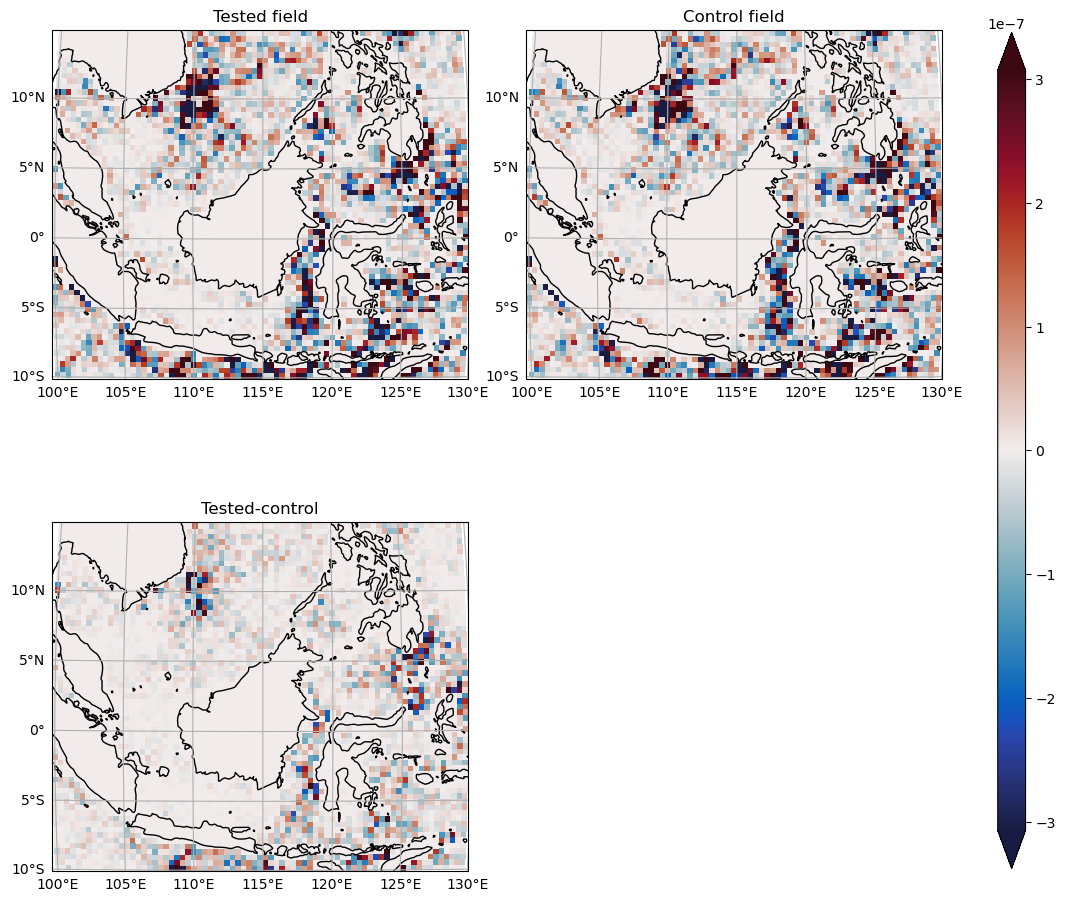

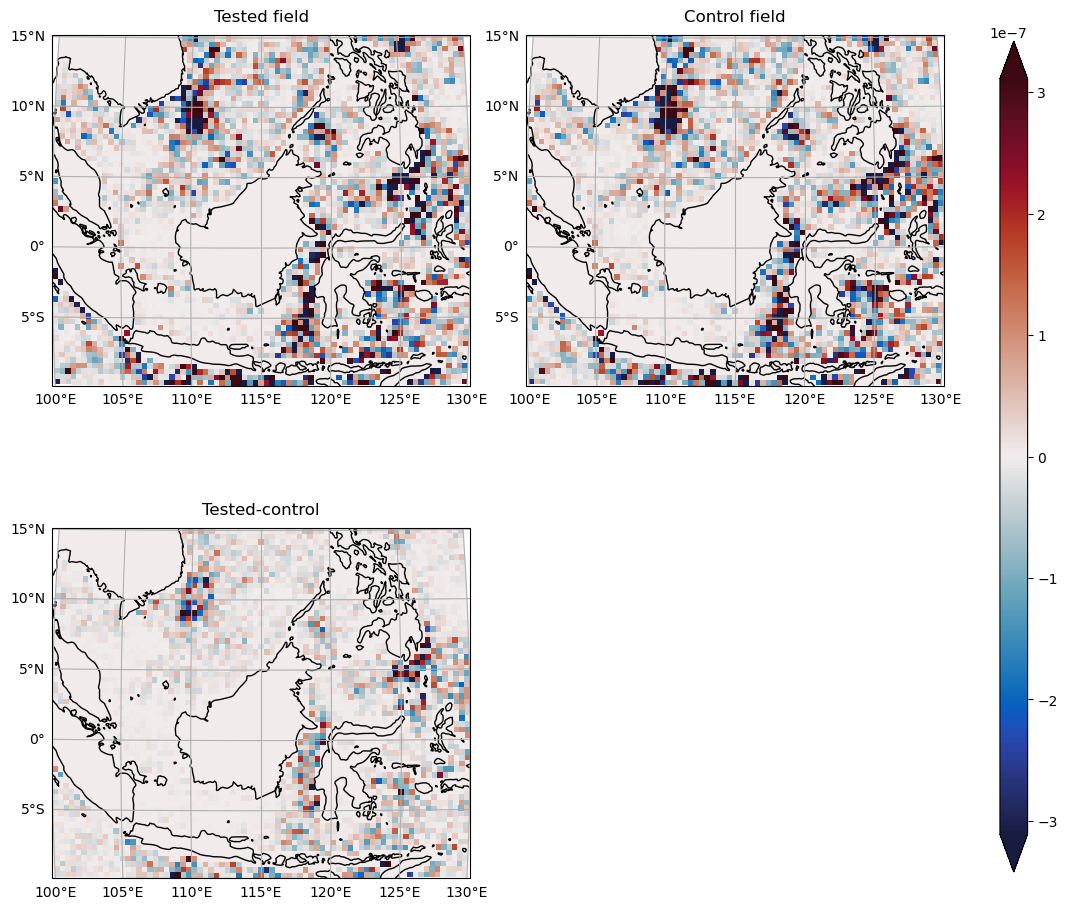

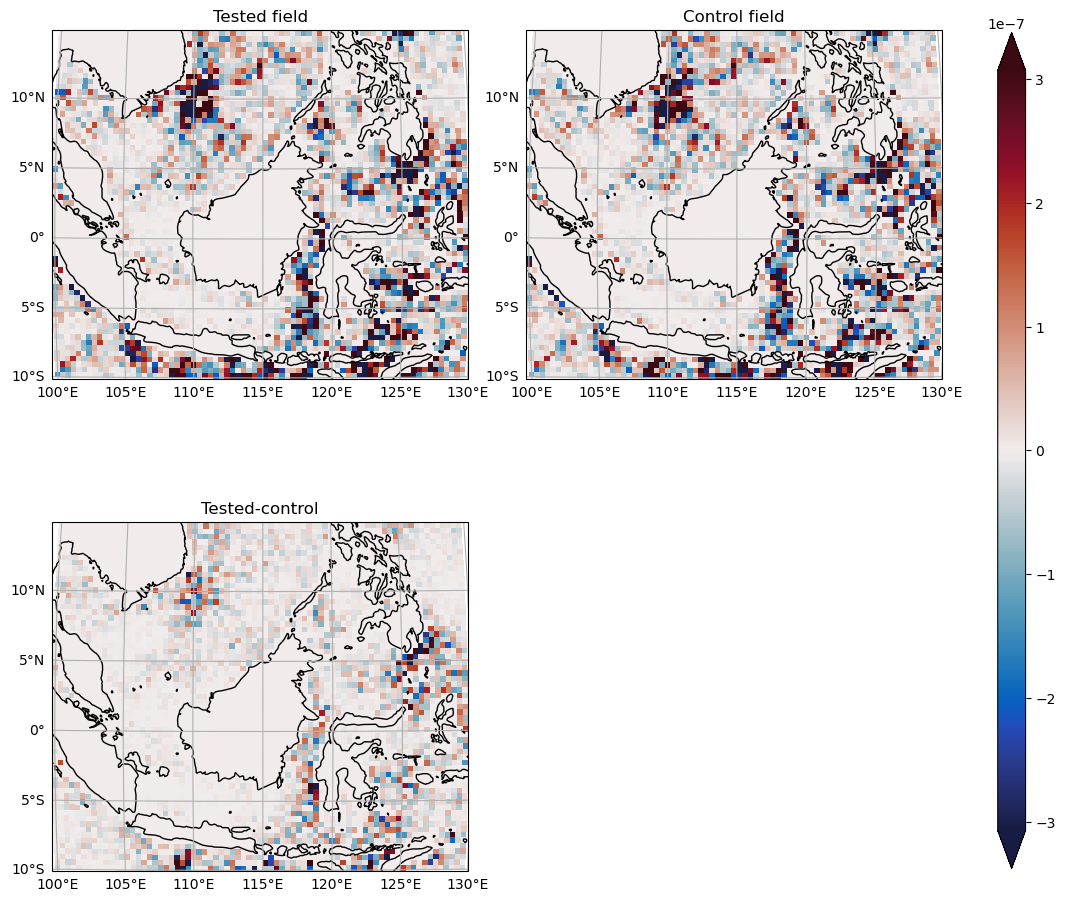

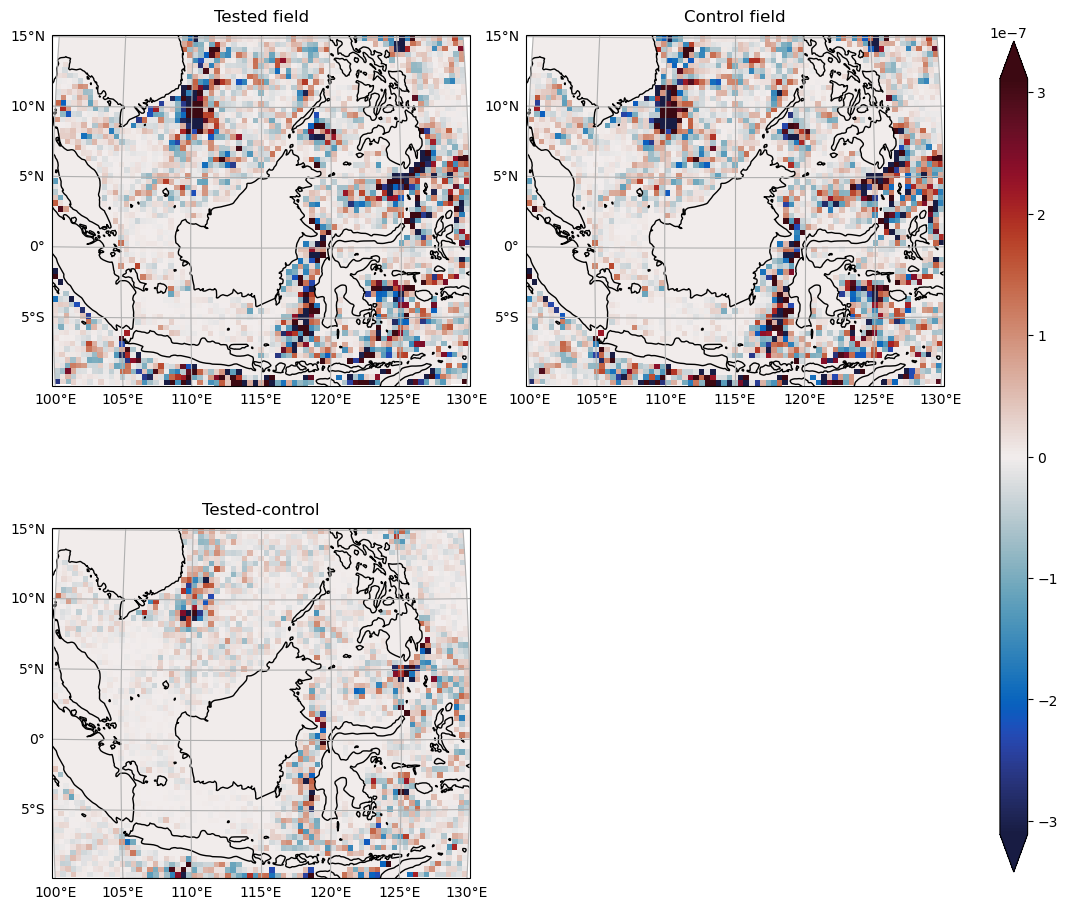

In [9]:
for time_revers in [False]:
    for rotation in [0, 90]:
        for reflect_x in [False, True]:
            for reflect_y in [False, True]:
                if rotation == 0 and not(reflect_x) and not(reflect_y) and not(time_revers):
                    pass
                else:
                    test = dataset.state.ANN(ann_Txy, ann_Txx_Tyy, 
                        rotation=rotation, reflect_x=reflect_x, reflect_y=reflect_y, time_revers=time_revers)

                    for field in ['ZB20u', 'ZB20v']:
                        compare(test[field], ann[field], selector=select_Cem)
                        print('\n')

# Testing energy cospectrum

In [29]:
time_id = np.random.randint(6950,8035)

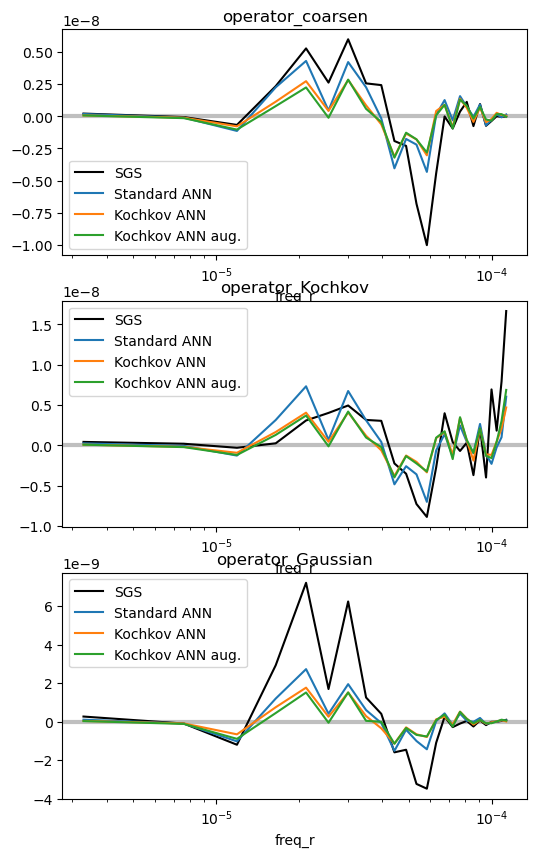

In [30]:
plt.figure(figsize=(6,10))
for row, (operator, title) in enumerate(zip([operator_coarsen, operator_Kochkov, operator_gaussian], ['operator_coarsen', 'operator_Kochkov', 'operator_Gaussian'])):
    dataset = ds.sample_epoch(time=time_id, operator=operator, factors=[4])[4]
    plt.subplot(3,1,row+1)
    kw_sp = dict(region='Pacific')
    dataset.state.transfer(dataset.data.SGSx, dataset.data.SGSy, **kw_sp).plot(color='k', label='SGS')
    # Standard ANN
    ann_Txy = import_ANN('trained_models/ANN_CM26/Txy_epoch_2000.nc')
    ann_Txx_Tyy = import_ANN('trained_models/ANN_CM26/Txx_Tyy_epoch_2000.nc')
    dataset.state.transfer_ANN(ann_Txy, ann_Txx_Tyy, kw_sp=kw_sp).plot(label='Standard ANN')
    # Kochkov ANN
    ann_Txy = import_ANN('trained_models/ANN_CM26_Kochkov/Txy_epoch_2000.nc')
    ann_Txx_Tyy = import_ANN('trained_models/ANN_CM26_Kochkov/Txx_Tyy_epoch_2000.nc')
    dataset.state.transfer_ANN(ann_Txy, ann_Txx_Tyy, kw_sp=kw_sp).plot(label='Kochkov ANN')

    # Kochkov ANN augmented
    ann_Txy = import_ANN('trained_models/ANN_CM26_Kochkov_augmented/Txy_epoch_100.nc')
    ann_Txx_Tyy = import_ANN('trained_models/ANN_CM26_Kochkov_augmented/Txx_Tyy_epoch_100.nc')
    dataset.state.transfer_ANN(ann_Txy, ann_Txx_Tyy, kw_sp=kw_sp).plot(label='Kochkov ANN aug.')

    
    plt.xscale('log')
    plt.axhline(y=0, color='gray', alpha=0.5, lw=3, zorder=-1)
    plt.legend()
    plt.title(title)

# Dissipation analysis

In [105]:
dataset = ds.sample_epoch(time=np.random.randint(6950,8035))[20]

Text(0.5, 1.0, 'Energy source')

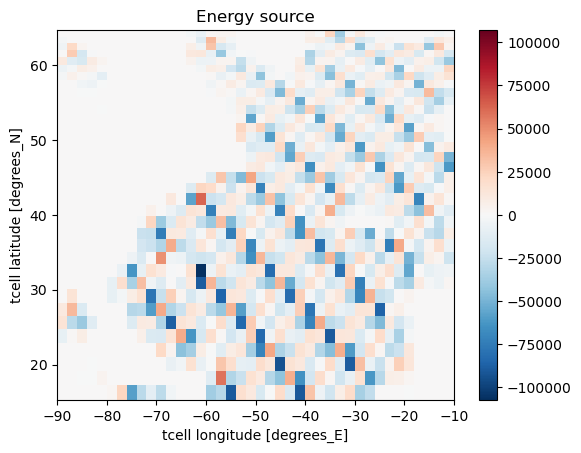

In [175]:
ann_Txy = import_ANN('trained_models/ANN_CM26_Kochkov_augmented/Txy_epoch_100.nc')
ann_Txx_Tyy = import_ANN('trained_models/ANN_CM26_Kochkov_augmented/Txx_Tyy_epoch_100.nc')

diss = dataset.state.sample_grid_harmonic(grid_harmonic='plane_wave').EZ_source_ANN(ann_Txy, ann_Txx_Tyy)
select_NA(diss['dEdt_G']).plot()
plt.title('Energy source')